# Rasterio

In the previous notebook we focused on the Numpy package using [Rasterio](https://rasterio.readthedocs.io/en/latest/) as the interface to read the data from disk. 

Whereas Numpy is a powerful package for calculation, it does not provide any spatial information so lacking support for reprojection, warping,... Apart from reading in a broad set of GIS raster formats, Rasterio also provides some of these GIS raster operations.

In [66]:
import matplotlib.pyplot as plt

import geopandas as gpd

import rasterio
from rasterio.plot import plotting_extent, show, show_hist, reshape_as_image

Let's recap with what we did so far with Rasterio:

In [80]:
data_file = "./data/herstappe/raster/2020-09-17_Sentinel_2_L1C_True_color.tiff"

In [300]:
with rasterio.open(data_file) as src:    
    herstappe_data = src.read([1, 2, 3], out_dtype=float, masked=False) # Note the float as output
    herstappe_profile = src.profile
    herstappe_ext = plotting_extent(src)

In [82]:
herstappe_array.shape, herstappe_array.dtype

((3, 227, 447), dtype('float64'))

## Convenient plot functions for data exploration

Rasterio provides dedicated plot functions `show` and `show_hist` for quick ddata exploration:

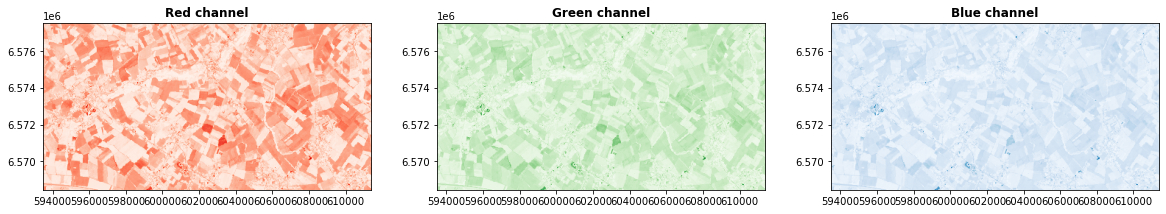

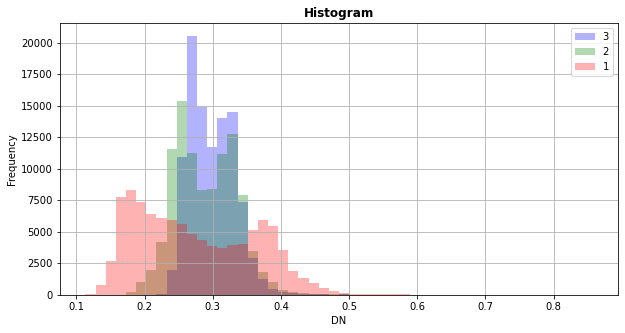

In [63]:
with rasterio.open(data_file) as src:
    
    # convenience plot functions from rasterio
    fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(20, 10))
    show((src, 1), ax=axr, cmap='Reds', title='Red channel')
    show((src, 2), ax=axg, cmap='Greens', title='Green channel')
    show((src, 3), ax=axb, cmap='Blues', title='Blue channel')
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    show_hist(src, bins=50, lw=0.0, stacked=False, 
          alpha=0.3, histtype='stepfilled', title="Histogram")

__Note:__ Rasterio directly interacts with Matplotlib objects, so adjustments starting from the figure can be done using the Matplotlib syntax. For example, change the title and the legend labels:

In [49]:
_, current_labels = ax.get_legend_handles_labels()
current_labels

['3', '2', '1']

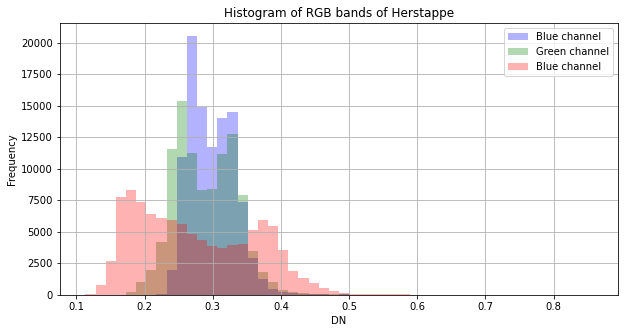

In [50]:
ax.set_title("Histogram of RGB bands of Herstappe")
ax.legend(["Blue channel", "Green channel", "Blue channel"])
fig

__Reminder on opening and Closing File Connections__

The Rasterio library is efficient as it establishes a connection with the raster file rather than directly reading it into memory. Because it creates a connection, it is important that you close the connection after it is opened AND after you’ve finished working with the data! That is why we use the context manager to work with raster data in rasterio. This will handle opening and closing the raster file for you.

__Utility functions for reshaping__

In [280]:
#plt.imshow(herstappe_data)

Python image processing software packages and Matplotlib organize arrays differently than Rasterio. The interpretation of a 3-dimension array read from rasterio is:

`(bands, rows, columns)`

while Matplotlib and image processing software like scikit-image, pillow are generally ordered:

`(rows, columns, bands)`

We can rely on Numpy to transpose the data : 

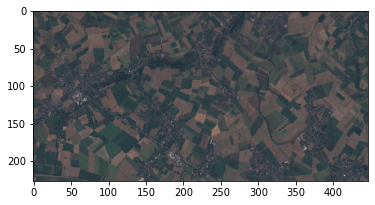

In [301]:
plt.imshow(herstappe_data.transpose(1, 2, 0))

But Rasterio also provides the utility functions `reshape_as_image` and `reshape_as_raster` to support the conversion:

In [302]:
from rasterio.plot import reshape_as_image, reshape_as_raster

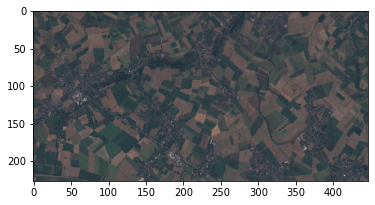

In [303]:
plt.imshow(reshape_as_image(herstappe_data))

## Extract the data you need

In many applications, a specific research area is used. Extracting the data you need from a given raster data set by a vector (polygon) file is a common operation in GIS analysis. We use the clipping example to explain the typical workflow in Rasterio.

For our Herstappe example, the study area is availabe as vector data `./data/herstappe/vector/herstappe.geojson`:

In [308]:
herstappe_vect = gpd.read_file("./data/herstappe/vector/herstappe.geojson")
herstappe_vect

,gml_id,UIDN,OIDN,TERRID,NISCODE,NAAM,DATPUBLBS,NUMAC,geometry
0,Refgem.202,642.0,37.0,59.0,73028,Herstappe,1831-02-07,,"MULTIPOLYGON (((5.41544 50.72148, 5.41568 50.7..."


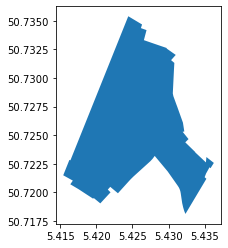

In [314]:
herstappe_vect.plot()

In [370]:
# herstappe_vect.crs  # vs herstappe_profile["crs"]

Make sure both data sets are defined in the same CRS and extracting the geometry can be used as input for the masking:

In [315]:
herstappe_vect = herstappe_vect.to_crs(epsg=3857)

[Masking a raster](https://rasterio.readthedocs.io/en/latest/quickstart.html#dataset-georeferencing) with a geometry in Rasterio is supported by the `rasterio.mask` module:

In [230]:
import rasterio.mask

In [231]:
#?rasterio.mask.mask

The `mask` function by default just masks the image, but it can also be used to `crop` the data by setting the `crop` argument to True:

As the required input for the `shape` to mask with, the documentation defines: 
    
    The values must be a GeoJSON-like dict or an object that implements
    the Python geo interface protocol (such as a Shapely Polygon).
    
We learnt earlier that GeoPandas relies on Shapely as spatial entities:

In [371]:
type(herstappe_vect.geometry), type(herstappe_vect.geometry[0])

(geopandas.geoseries.GeoSeries, shapely.geometry.multipolygon.MultiPolygon)

We can do the data extraction (masking) within the context manager:

In [372]:
data_file = "./data/herstappe/raster/2020-09-17_Sentinel_2_L1C_True_color.tiff"

In [373]:
with rasterio.open(data_file) as src:
    out_image, out_transform = rasterio.mask.mask(src, herstappe_vect.geometry, crop=True)
    herstappe_profile = src.profile
    herstappe_ext = plotting_extent(src)

In [374]:
type(out_image)

numpy.ndarray

We can work with `out_image` as a numpy array, but we are lacking the spatial information by doing so, which makes it hard to combine it with other spatial data sets for further analysis:

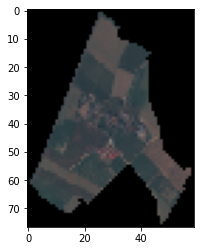

In [375]:
plt.imshow(reshape_as_image(out_image)) # extent ?!? extent=herstappe_ext would not be correct.

Remember the `meta` and the `profile` attributes of the Rasterio object? The latter contains the spatial information and the settings for the GeoTiff file:

In [376]:
herstappe_profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 447, 'height': 227, 'count': 3, 'crs': CRS.from_epsg(3857), 'transform': Affine(40.07813983073409, 0.0, 593476.1968631798,
       0.0, -40.1126034998577, 6577549.60336745), 'tiled': False, 'compress': 'deflate', 'interleave': 'pixel'}

In [377]:
out_image.shape

(3, 77, 59)

To contain the spatial information or save the file for later usage keeping the spatial information, make sure to __update the profile metadata__ according to the transformations you did. In this case:

- width/height of the cropped image
- affine transform function

In [378]:
herstappe_profile.update({"height": out_image.shape[1],
                          "width": out_image.shape[2],
                          "transform": out_transform})

In [379]:
herstappe_profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 59, 'height': 77, 'count': 3, 'crs': CRS.from_epsg(3857), 'transform': Affine(40.07813983073409, 0.0, 602814.4034437408,
       0.0, -40.1126034998577, 6574661.49591546), 'tiled': False, 'compress': 'deflate', 'interleave': 'pixel'}

Just as before, we can use the `plotting_extent` function to extract the extent of our data, using the outputs of the masking:

In [380]:
new_extent = plotting_extent(out_image[0], out_transform)  # see docstring of plotting_extent on [0] requirement

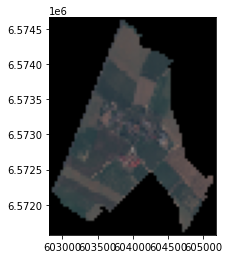

In [381]:
plt.imshow(reshape_as_image(out_image), extent=new_extent)

The updated profile information also allows us to store the output as a Geotiff file:

In [382]:
with rasterio.open("./test.tiff", "w", **herstappe_profile) as dest:
    dest.write(out_image)

Let's read the data we just saved to a file:

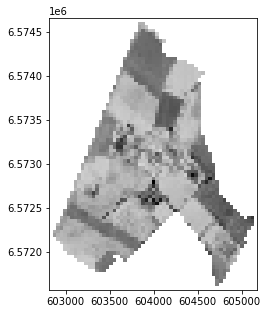

In [383]:
with rasterio.open("./test.tiff") as clipped:
    fig, ax = plt.subplots(figsize=(12, 5))
    show(clipped, (1, 2, 3), cmap='Greys')

    clipped_ext = plotting_extent(clipped)
    clipped_array = clipped.read([1, 2, 3], 
                                 out_dtype=float, masked=False)

Quick check if the extent in both situations are the same:

In [384]:
new_extent == clipped_ext

True

## Rasterio workflow

The workflow applied to clip the data set is typical when working with Rasterio. It consists of the following main steps:

```
# 1
with rasterio.open(data_file) as src:  

    # 2
    out_image, out_transform = rasterio.mask.mask(src, 
        herstappe_vect.geometry, crop=True)    
    
    # 3
    herstappe_profile = src.profile
    herstappe_profile.update({"height": out_image.shape[1],
                              "width": out_image.shape[2],
                              "transform": out_transform})  
    # 4                              
    with rasterio.open("./test.tiff", "w", **herstappe_profile) as dest: 
        dest.write(out_image)
```

- 1. Read in a data set using the context manager
- 2. Read and transform the data set by clipping, resampling,...
- 3. Update the spatial metadata/profile of the data set
- 4. Save the new data set with the updated metadata/profile

Similar operations are:

- Reprojecting a data set, see https://rasterio.readthedocs.io/en/latest/topics/reproject.html
- Resampling a data set, see https://rasterio.readthedocs.io/en/latest/topics/resampling.html

Let's apply this workflow to resample our data set with a factor 2, i.e. doubling the pixel size:

In [388]:
data_file = "./data/herstappe/raster/2020-09-17_Sentinel_2_L1C_True_color.tiff"

In [390]:
import rasterio
from rasterio.enums import Resampling

scaling_factor = 2 

with rasterio.open(data_file) as src:  # 1

    # resample data to target shape  # 2
    new_width = int(src.width / scaling_factor)
    new_height = int(src.height / scaling_factor)
    out_image = src.read(
        out_shape=(src.count, new_height, new_width),
        resampling=Resampling.bilinear
    )

    # scale image transform and update metadata  # 3
    data_profile = src.profile
    out_transform = src.transform * src.transform.scale(scaling_factor)
    data_profile.update({"height": new_height,
                         "width": new_width,
                         "transform": out_transform})      

    # save the output to disk # 4
    with rasterio.open("./test_resample.tiff", "w", **data_profile) as dst:
        dst.write(data)

In [391]:
#!gdalinfo ./data/herstappe/raster/2020-09-17_Sentinel_2_L1C_True_color.tiff
#!gdalinfo ./test_resample.tiff

<div class="alert alert-success">

**EXERCISE**:

Make a plot of the `herstappe_data`, `./data/herstappe/raster/2020-09-17_Sentinel_2_L1C_True_color.tiff`, together with the `herstappe_vect`, `./data/herstappe/vector/herstappe.geojson` in a single Matplotlib image.
    
<details><summary>Hints</summary>

* Make sure to align the CRS of both the vector as the raster data set.
* Remember the `extent` trick to use the coordinates as Matplotlib axis?
* The Matplotlib `plot` function provides `color`, `edgecolor`,... to adjust the style of the plot.
    
</details>
    
</div>

In [ ]:
herstappe_vect = gpd.read_file("./data/herstappe/vector/herstappe.geojson")

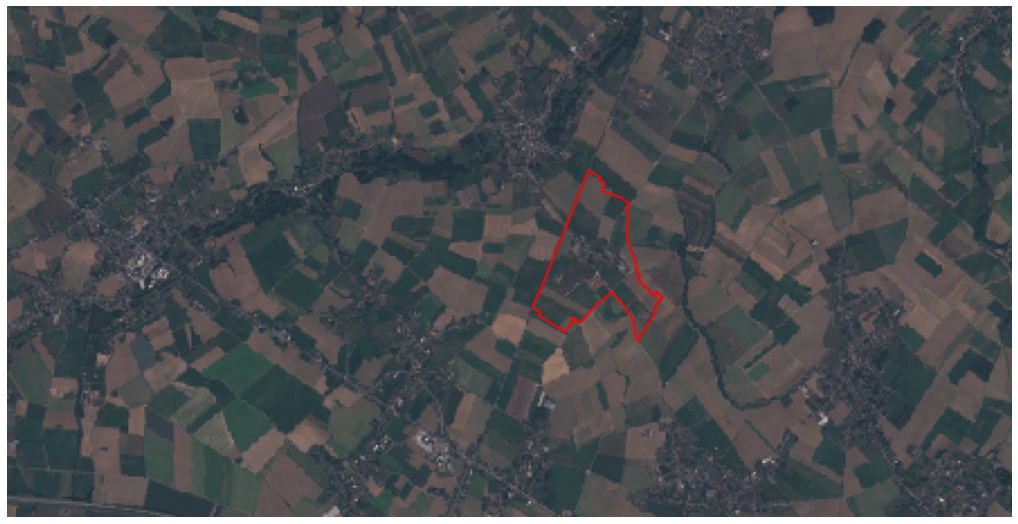

In [274]:
fig, ax = plt.subplots(figsize=(18, 15))
ax.imshow(reshape_as_image(herstappe_data), extent=herstappe_ext)  # Extent trick to plot numpy
herstappe_vect_3857 = herstappe_vect.to_crs(epsg=3857)
herstappe_vect_3857.plot(color='None', edgecolor='red', linewidth=2, ax=ax)
ax.axis('off');

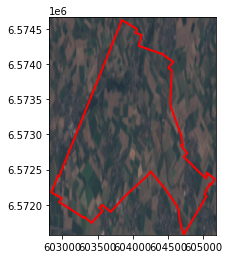

In [392]:
fig, ax = plt.subplots()
ax.imshow(reshape_as_image(out_image), 
          extent=clipped_ext);
herstappe_vect.to_crs(epsg=3857).plot(color='None', edgecolor='red', linewidth=2, ax=ax)

In [ ]:
<div class="alert alert-info" style="font-size:120%">

**REMEMBER**: <br>

When 

</div>

- Maskgin shapes into a raster - https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html
- Easy plotting functions
- Workflow: READ, adjust, update profile/meta, write - https://rasterio.readthedocs.io/en/latest/topics/profiles.html
- Only read what you need into memory
- reproject, resample, window

__Opening and Closing File Connections__

The rasterio library is efficient as it establishes a connection with the raster file rather than directly reading it into memory. Because it creates a connection, it is important that you close the connection after it is opened AND after you’ve finished working with the data! A better way to work with raster data in rasterio is to use the context manager. This will handle opening and closing the raster file for you.

In [ ]:
# ...